In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [3]:
### 데이터 로드
data = pd.read_csv('dataset/ethereum_dataset.csv', index_col=0)
data.head()

,Open*,High,Low,Close**,Volume,Market Cap
Date,,,,,,
2019-08-13,211.34,211.38,205.42,208.71,5946313205,2.239653e+10
2019-08-12,216.06,216.14,210.95,211.29,5674315559,2.267042e+10
2019-08-11,206.73,216.60,206.51,216.09,6440605605,2.318300e+10
2019-08-10,210.53,213.73,203.79,206.73,6584748527,2.217611e+10
2019-08-09,220.91,221.36,208.25,210.49,6964818795,2.257606e+10


In [3]:
### 데이터 전처리
high_prices = data['High'].values
low_prices = data['Low'].values
volume_prices = data['Volume'].values

mid_prices = (high_prices + low_prices) / 2

seq_len = 30
sequence_length = seq_len + 1

price = []
for index in range(len(mid_prices) - sequence_length):
    price.append(mid_prices[index: index + sequence_length])

In [4]:
### 데이터 정규화 - price
def price_normalize_windows(data):
    normalized_data = []

    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data)

norm_price = price_normalize_windows(price)

In [5]:
### 데이터 정규화 - volume
def volume_normalize_windows(data):
    normalized_data = []
    avg_window = sum(data, 0.0) / len(data)
    
    for window in data:
        normalized_window = (window / avg_window) -1
        normalized_data.append(normalized_window)

    return np.array(normalized_data)

norm_volume = volume_normalize_windows(volume_prices)


In [6]:
### 데이터 분할
def data_gethering(price, volume):    
    data_size = price.shape[0]
    result =[]

    for i in range(data_size):
        temp = np.insert(price[i],-1,volume[i])
        result.append(temp)
        
    return np.array(result)

norm_result = data_gethering(norm_price, norm_volume)

In [7]:
train_cut = int(round(norm_result.shape[0] * 0.90))
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = norm_result[train_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[train_cut:, -1]

x_train.shape, x_test.shape

((1292, 31, 1), (143, 31, 1))

In [8]:
### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [9]:
### 모델 설계
model = Sequential()

for i in range (4):
    model.add(LSTM(31, return_sequences=True, input_shape=(31, 1)))   

model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='adam')

model.summary()

W0813 16:54:42.305854 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 16:54:42.533434 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 16:54:42.599328 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0813 16:54:43.533947 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 31, 31)            4092      
_________________________________________________________________
lstm_2 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_3 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_4 (LSTM)                (None, 31, 31)            7812      
_________________________________________________________________
lstm_5 (LSTM)                (None, 30)                7440      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 34,999
Trainable params: 34,999
Non-trainable params: 0
_________________________________________________________________


In [10]:
### 학습 모델 로드
# model = load_model('ether_prediction_model_achi_1.h5')
# model = load_model('ether_prediction_model_achi_2.h5')
# model = load_model('ether_prediction_model_achi_3.h5')

In [11]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=30, epochs=20, callbacks=[cb_checkpoint])

W0813 16:54:46.485337 18056 deprecation.py:323] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0813 16:54:48.654371 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0813 16:54:48.819599 18056 deprecation_wrapper.py:119] From D:\_setup\anaconda3\envs\py3.7\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1292 samples, validate on 143 samples
Epoch 1/20
1292/1292 [==============================] - 25s 19ms/step - loss: 0.4407 - val_loss: 0.0598

Epoch 00001: val_loss improved from inf to 0.05976, saving model to ./model/01-0.0598.hdf5
Epoch 2/20
1292/1292 [==============================] - 14s 11ms/step - loss: 0.1545 - val_loss: 0.0507

Epoch 00002: val_loss improved from 0.05976 to 0.05072, saving model to ./model/02-0.0507.hdf5
Epoch 3/20
1292/1292 [==============================] - 13s 10ms/step - loss: 0.1198 - val_loss: 0.0475

Epoch 00003: val_loss improved from 0.05072 to 0.04753, saving model to ./model/03-0.0475.hdf5
Epoch 4/20
1292/1292 [==============================] - 13s 10ms/step - loss: 0.1012 - val_loss: 0.0238

Epoch 00004: val_loss improved from 0.04753 to 0.02385, saving model to ./model/04-0.0238.hdf5
Epoch 5/20
1292/1292 [==============================] - 13s 10ms/step - loss: 0.1012 - val_loss: 0.0476

Epoch 00005: val_loss did not improve from 0.02385
E

In [14]:
### 모델 저장
model. save('ether_prediction_model_achi_1.h5')

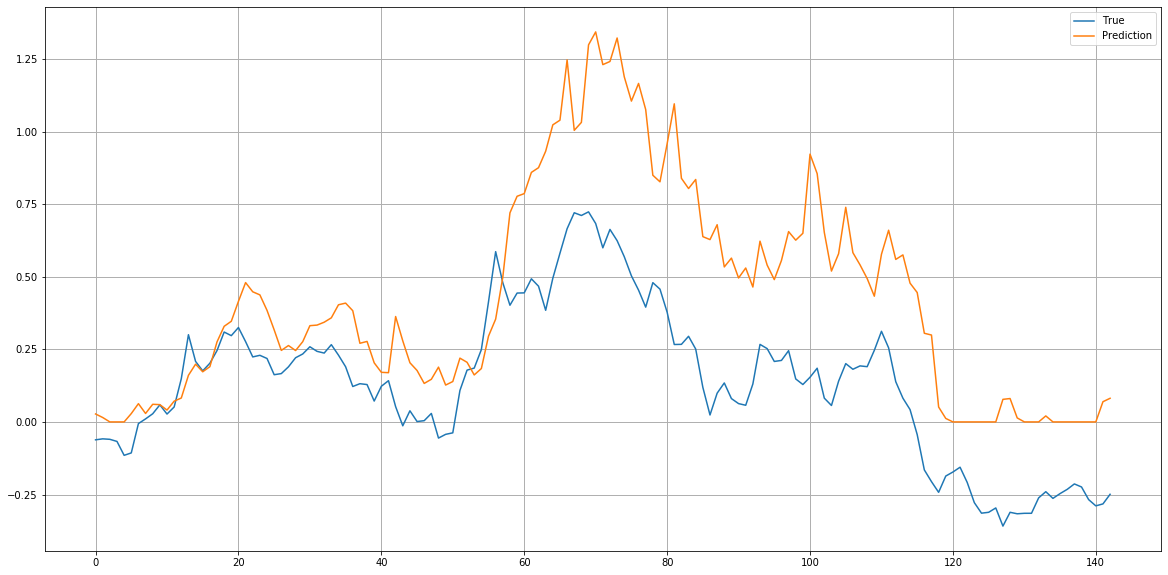

In [14]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
ax.grid(linestyle='-', linewidth=1,)
plt.show()

## Basic Architecture
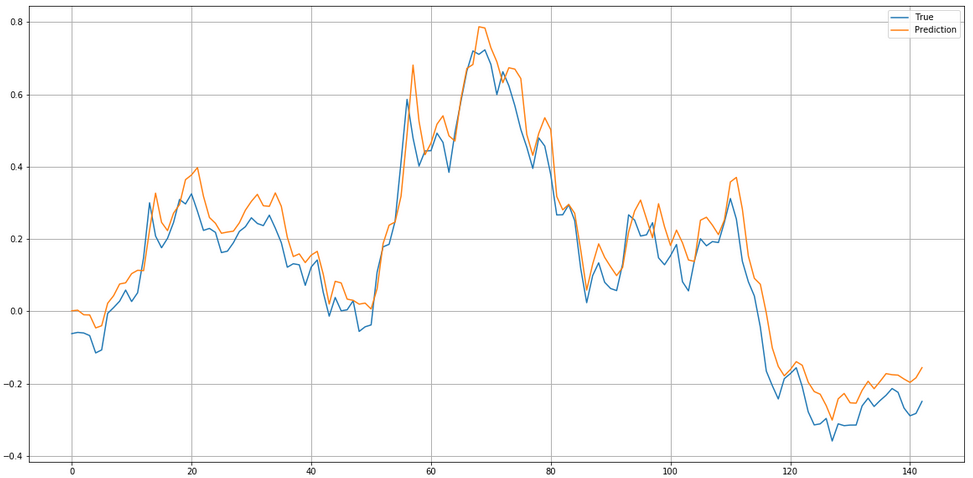
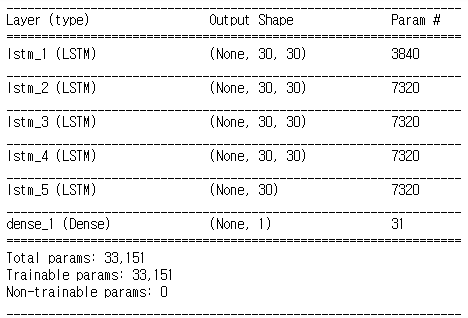

## Architecture 1
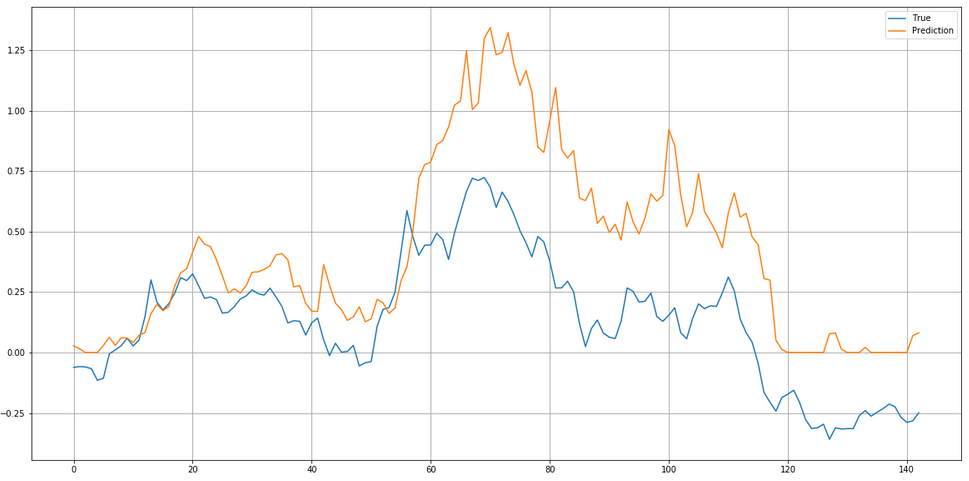

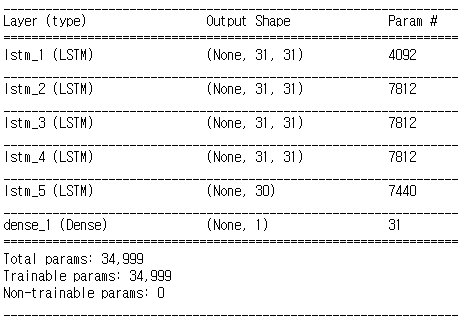



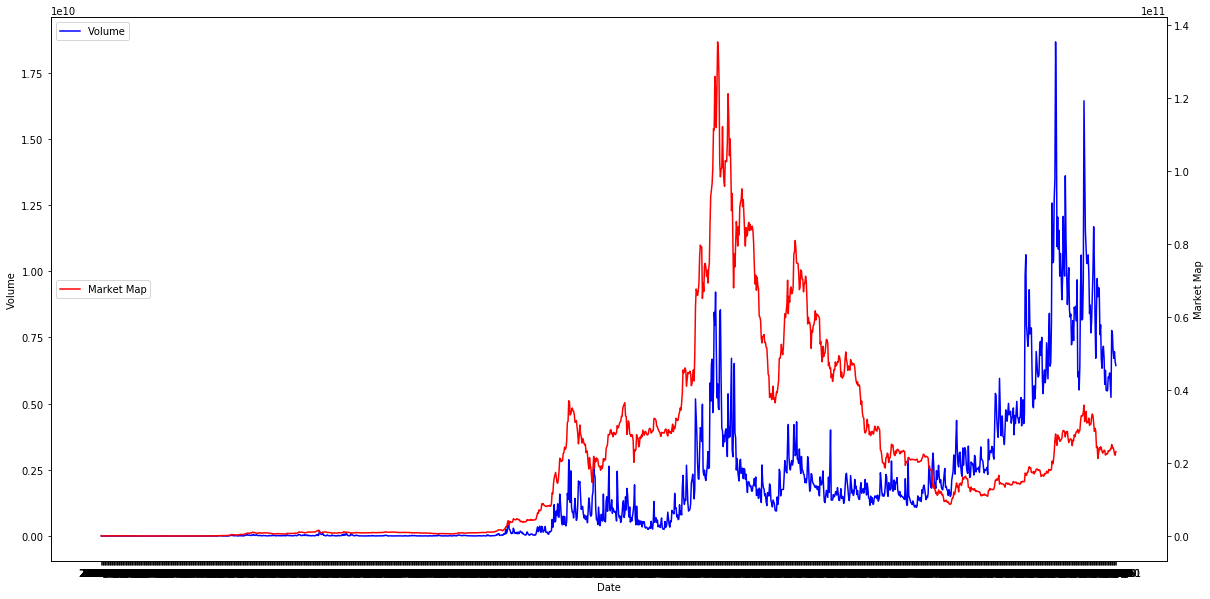

In [16]:
%matplotlib inline

fig = plt.figure(facecolor='white', figsize=(20, 10))
volume_ax = fig.add_subplot()
map_ax = volume_ax.twinx()


volume_ax.plot(data['Volume'], 'b', label='Volume')

map_ax.plot(data['Market Map'], 'r', label='Market Map')

volume_ax.set_xlabel('Date')
volume_ax.set_ylabel('Volume')
map_ax.set_ylabel('Market Map')

volume_ax.legend(loc='upper left')
map_ax.legend(loc='center left')
plt.show()

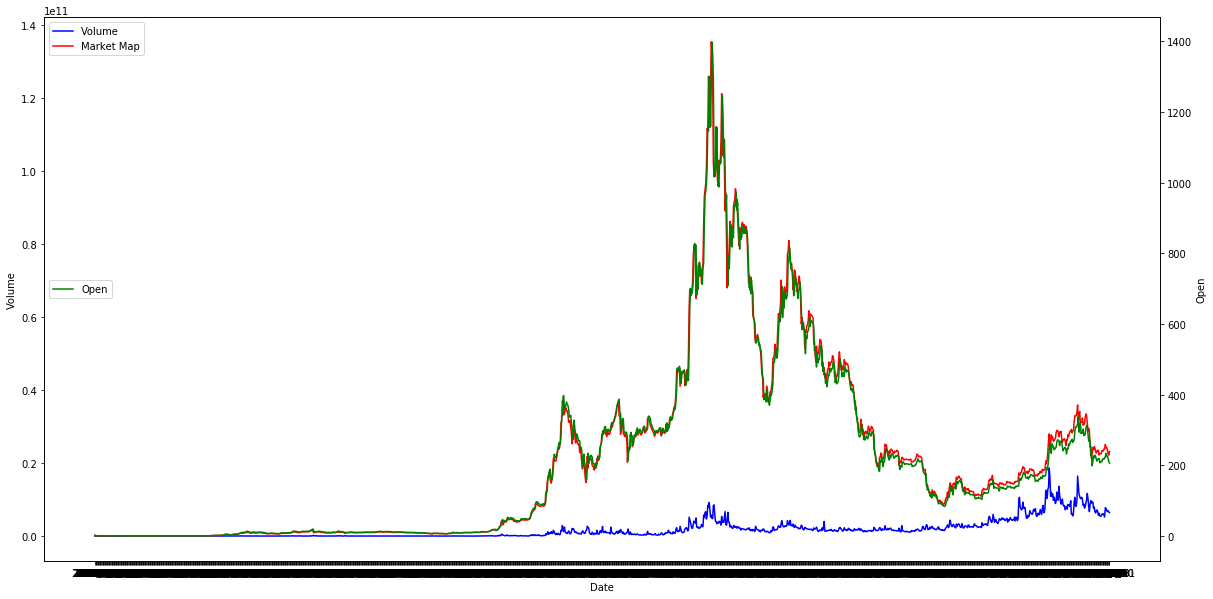

In [17]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
volume_ax = fig.add_subplot()
open_close_ax = volume_ax.twinx()


volume_ax.plot(data['Volume'], 'b', label='Volume')
volume_ax.plot(data['Market Map'], 'r', label='Market Map')

open_close_ax.plot(data['Open'], 'g', label='Open')


volume_ax.set_xlabel('Date')
volume_ax.set_ylabel('Volume')
open_close_ax.set_ylabel('Open')

volume_ax.legend(loc='upper left')
open_close_ax.legend(loc='center left')
plt.show()